### Using GPU with torch

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPUs available. Ensure CUDA is installed and configured.")

Using GPU: NVIDIA GeForce RTX 3090


Number of classes: 20
Epoch 1/20, Loss: 1.6062, F1-Score: 0.3163
Validation Loss: 0.8865, Validation F1-Score: 0.5367
Best model saved.
Epoch 2/20, Loss: 0.9667, F1-Score: 0.5395
Validation Loss: 0.6622, Validation F1-Score: 0.6136
Best model saved.
Epoch 3/20, Loss: 0.7849, F1-Score: 0.6140
Validation Loss: 0.5106, Validation F1-Score: 0.7156
Best model saved.
Epoch 4/20, Loss: 0.6697, F1-Score: 0.6521
Validation Loss: 0.4133, Validation F1-Score: 0.7388
Best model saved.
Epoch 5/20, Loss: 0.5843, F1-Score: 0.6976
Validation Loss: 0.3275, Validation F1-Score: 0.7676
Best model saved.
Epoch 6/20, Loss: 0.5124, F1-Score: 0.7249
Validation Loss: 0.3078, Validation F1-Score: 0.7889
Best model saved.
Epoch 7/20, Loss: 0.4575, F1-Score: 0.7372
Validation Loss: 0.3184, Validation F1-Score: 0.8293
Best model saved.
Epoch 8/20, Loss: 0.4182, F1-Score: 0.7655
Validation Loss: 0.2828, Validation F1-Score: 0.8145
Epoch 9/20, Loss: 0.3863, F1-Score: 0.7731
Validation Loss: 0.2562, Validation F1-Sc

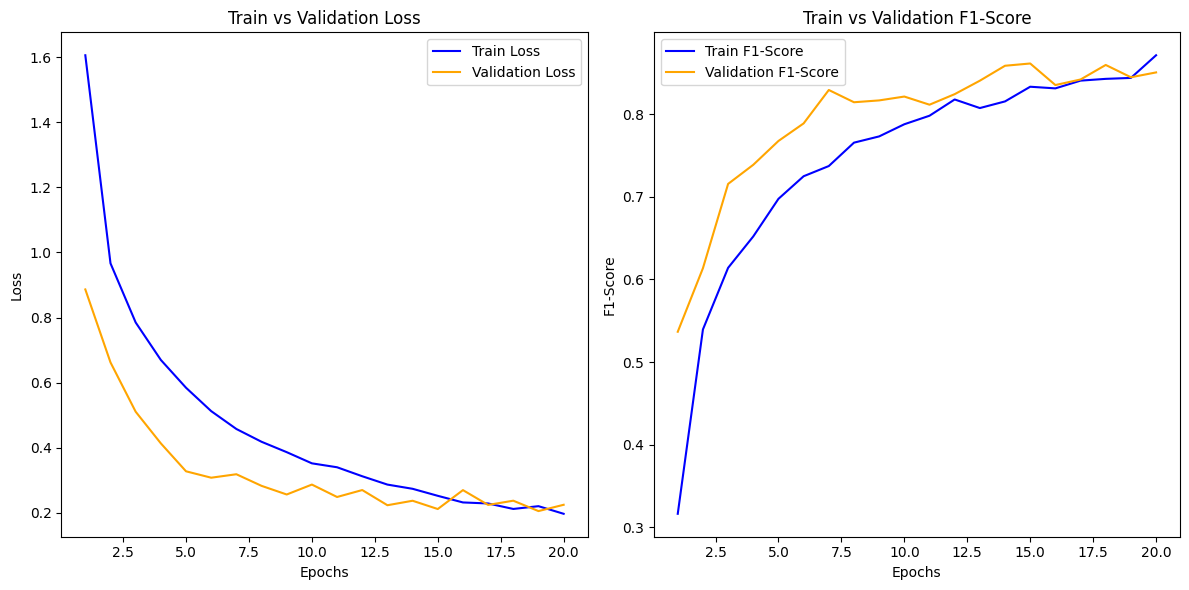

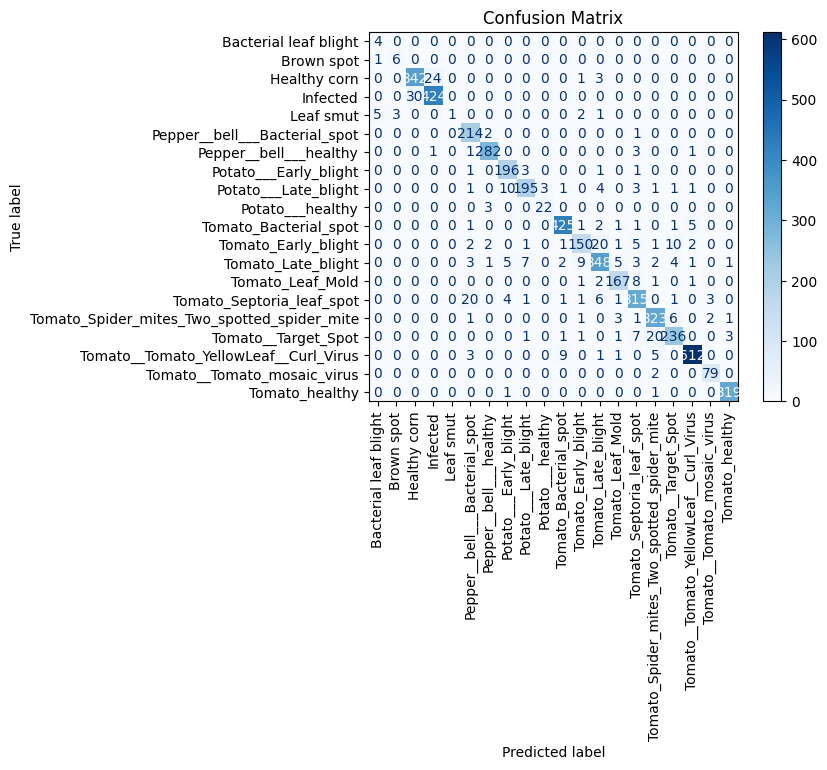

In [5]:
# Define paths
data_dir = 'clase'  # Path to the main folder containing subfolders (labels)
batch_size = 32
# Using a smaller dimension to train faster
img_height = 64
img_width = 64

# Define transforms 
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split dataset into training and validation sets
val_split = 0.2
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Get the number of classes
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

# Define a basic model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Calculate the flattened size dynamically
        with torch.no_grad():
            sample_input = torch.zeros(1, 3, img_height, img_width)
            flattened_size = self.features(sample_input).view(1, -1).size(1)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNNModel(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
best_val_f1 = 0.0
best_model_path = 'best_model.pth'

train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_losses.append(train_loss)
    train_f1_scores.append(train_f1)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, F1-Score: {train_f1:.4f}")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for val_images, val_labels_batch in val_loader:
            val_images, val_labels_batch = val_images.to(device), val_labels_batch.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels_batch)
            val_running_loss += val_loss.item()
            _, val_predicted = val_outputs.max(1)
            val_preds.extend(val_predicted.cpu().numpy())
            val_labels.extend(val_labels_batch.cpu().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)
    print(f"Validation Loss: {val_loss:.4f}, Validation F1-Score: {val_f1:.4f}")

    # Save the best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved.")

# Save the final model
final_model_path = 'final_model.pth'
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot F1-scores
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_f1_scores, label='Train F1-Score', color='blue')
plt.plot(range(1, epochs + 1), val_f1_scores, label='Validation F1-Score', color='orange')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('Train vs Validation F1-Score')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model and display the confusion matrix
model.load_state_dict(torch.load(best_model_path))
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for val_images, val_labels_batch in val_loader:
        val_images, val_labels_batch = val_images.to(device), val_labels_batch.to(device)
        val_outputs = model(val_images)
        _, val_predicted = val_outputs.max(1)
        val_preds.extend(val_predicted.cpu().numpy())
        val_labels.extend(val_labels_batch.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(val_labels, val_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=dataset.classes)
cmd.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()



### Applying data augemetation

In [4]:
# Salvarea modelului CNN antrenat pe date augmentate
final_model_path = "models/disease_detection_model.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Modelul final augmentat a fost salvat în: {final_model_path}")

NameError: name 'torch' is not defined

In [33]:
# Import necessary libraries
from torchvision.transforms.functional import rotate
import numpy as np
from PIL import Image  # Fix the missing Image import
from collections import Counter
from torch.utils.data import WeightedRandomSampler

# =========================================
# 1) Basic setup: device, seeds, directories
# =========================================
data_dir = "clase"  # Path to your data folder
batch_size = 32
img_height = 64
img_width = 64
val_split = 0.2

# -------------------------------------------------
# 1) Base transform (PIL only, no ToTensor)
# -------------------------------------------------
base_transform = transforms.Compose([
    transforms.Resize((img_height, img_width))
    # Keep as PIL image here
])

# -------------------------------------------------
# 2) Load dataset with base_transform
# -------------------------------------------------
dataset = datasets.ImageFolder(data_dir, transform=base_transform)

# Split into train / val
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print("Train size:", len(train_dataset))
print("Val size:  ", len(val_dataset))

# Check class distributions
train_labels_list = [lbl for _, lbl in train_dataset]
val_labels_list   = [lbl for _, lbl in val_dataset]
print("Training class distribution:", Counter(train_labels_list))
print("Validation class distribution:", Counter(val_labels_list))

# Quick unaugmented loaders (if needed)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

num_classes = len(dataset.classes)
print("Number of classes:", num_classes)

# -------------------------------------------------
# 3) Model definition (same as before)
# -------------------------------------------------
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Dynamically figure out flattened size
        with torch.no_grad():
            sample_input = torch.zeros(1, 3, img_height, img_width)
            flattened_size = self.features(sample_input).view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate model, loss, optimizer
model = CNNModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------------------------------
# 4) Custom Salt-and-Pepper (lower probability)
# -------------------------------------------------
class AddSaltAndPepperNoise:
    def __init__(self, prob=0.02):  # Reduced from 0.05
        self.prob = prob

    def __call__(self, img):
        np_img = np.array(img)  # [H,W,C] or [H,W]
        if np_img.ndim == 3:
            h, w, c = np_img.shape
            for ch in range(c):
                mask = np.random.choice(
                    [0, 1, 2],
                    size=(h, w),
                    p=[self.prob/2, self.prob/2, 1 - self.prob]
                )
                # 0 => black (salt), 255 => white (pepper)
                np_img[:, :, ch][mask == 0] = 0
                np_img[:, :, ch][mask == 1] = 255
        else:
            # grayscale
            h, w = np_img.shape
            mask = np.random.choice(
                [0, 1, 2],
                size=(h, w),
                p=[self.prob/2, self.prob/2, 1 - self.prob]
            )
            np_img[mask == 0] = 0
            np_img[mask == 1] = 255

        np_img = np.clip(np_img, 0, 255).astype(np.uint8)
        if np_img.ndim == 2:
            return Image.fromarray(np_img, mode='L')
        else:
            return Image.fromarray(np_img, mode='RGB')

# -------------------------------------------------
# 5) Final transform = ToTensor + Normalize
# -------------------------------------------------
final_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                         [0.5,0.5,0.5])
])

# -------------------------------------------------
# 6) Create exactly 4 new images per original
#    (S&P only on original, plus 3 rotations)
# -------------------------------------------------
def augment_4_images(dataset, final_tsfm):
    """
    For each PIL 'img':
      1. Original + salt/pepper
      2. Rotate 90
      3. Rotate 180
      4. Rotate 270
    Then apply final_tsfm to each (ToTensor + Normalize).
    Returns lists of Tensors, labels.
    """
    augmented_images = []
    augmented_labels = []
    
    sp_noise = AddSaltAndPepperNoise(prob=0.02)  # or pass as param

    for pil_img, label in dataset:
        # (1) Original with salt & pepper
        orig_sp = sp_noise(pil_img)
        orig_sp_tensor = final_tsfm(orig_sp)

        # (2) Rot90 (no noise)
        rot90 = rotate(pil_img, 90)
        rot90_tensor = final_tsfm(rot90)

        # (3) Rot180 (no noise)
        rot180 = rotate(pil_img, 180)
        rot180_tensor = final_tsfm(rot180)

        # (4) Rot270 (no noise)
        rot270 = rotate(pil_img, 270)
        rot270_tensor = final_tsfm(rot270)

        # Add them all
        augmented_images.extend([orig_sp_tensor, rot90_tensor,
                                 rot180_tensor, rot270_tensor])
        augmented_labels.extend([label, label, label, label])

    return augmented_images, augmented_labels

# Generate augmented data (4x the dataset size)
aug_images, aug_labels = augment_4_images(train_dataset, final_transform)

# -------------------------------------------------
# 7) Wrap in a TensorDataset/DataLoader
# -------------------------------------------------
combined_data = torch.stack(aug_images)  # shape [N, C, H, W]
combined_labels = torch.tensor(aug_labels)

train_dataset_augmented = TensorDataset(combined_data, combined_labels)
train_loader_augmented = DataLoader(train_dataset_augmented,
                                    batch_size=batch_size,
                                    shuffle=True)

# -------------------------------------------------
# 8) Validation set as Tensors
#    (or just keep your original method)
# -------------------------------------------------
val_imgs, val_lbls = zip(*[(img, lbl) for img, lbl in val_dataset])
to_pil = transforms.ToPILImage()
resize_transform = transforms.Resize((img_height, img_width))

val_tensors = []
for img in val_imgs:
    # If it's already a PIL, no need for to_pil, but just in case
    if isinstance(img, torch.Tensor):
        img = to_pil(img)
    val_pil = resize_transform(img)
    # Minimal transform => to Tensor (and optionally normalize)
    val_tensor = transforms.ToTensor()(val_pil)
    # Or do transforms.Normalize(...) here if you want
    val_tensors.append(val_tensor)

val_data = torch.stack(val_tensors)
val_labels = torch.tensor(val_lbls)
val_dataset_augmented = TensorDataset(val_data, val_labels)
val_loader_augmented = DataLoader(val_dataset_augmented,
                                  batch_size=batch_size,
                                  shuffle=False)

Train size: 19987
Val size:   4996
Training class distribution: Counter({17: 2586, 3: 1768, 10: 1692, 2: 1591, 12: 1502, 14: 1407, 15: 1383, 19: 1285, 6: 1188, 16: 1127, 11: 810, 8: 809, 7: 781, 5: 773, 13: 750, 18: 310, 9: 125, 1: 34, 4: 33, 0: 33})
Validation class distribution: Counter({17: 622, 3: 457, 10: 435, 2: 409, 12: 407, 14: 364, 19: 306, 15: 293, 6: 290, 16: 277, 5: 224, 7: 219, 13: 202, 8: 191, 11: 190, 18: 63, 9: 27, 4: 7, 0: 7, 1: 6})
Number of classes: 20


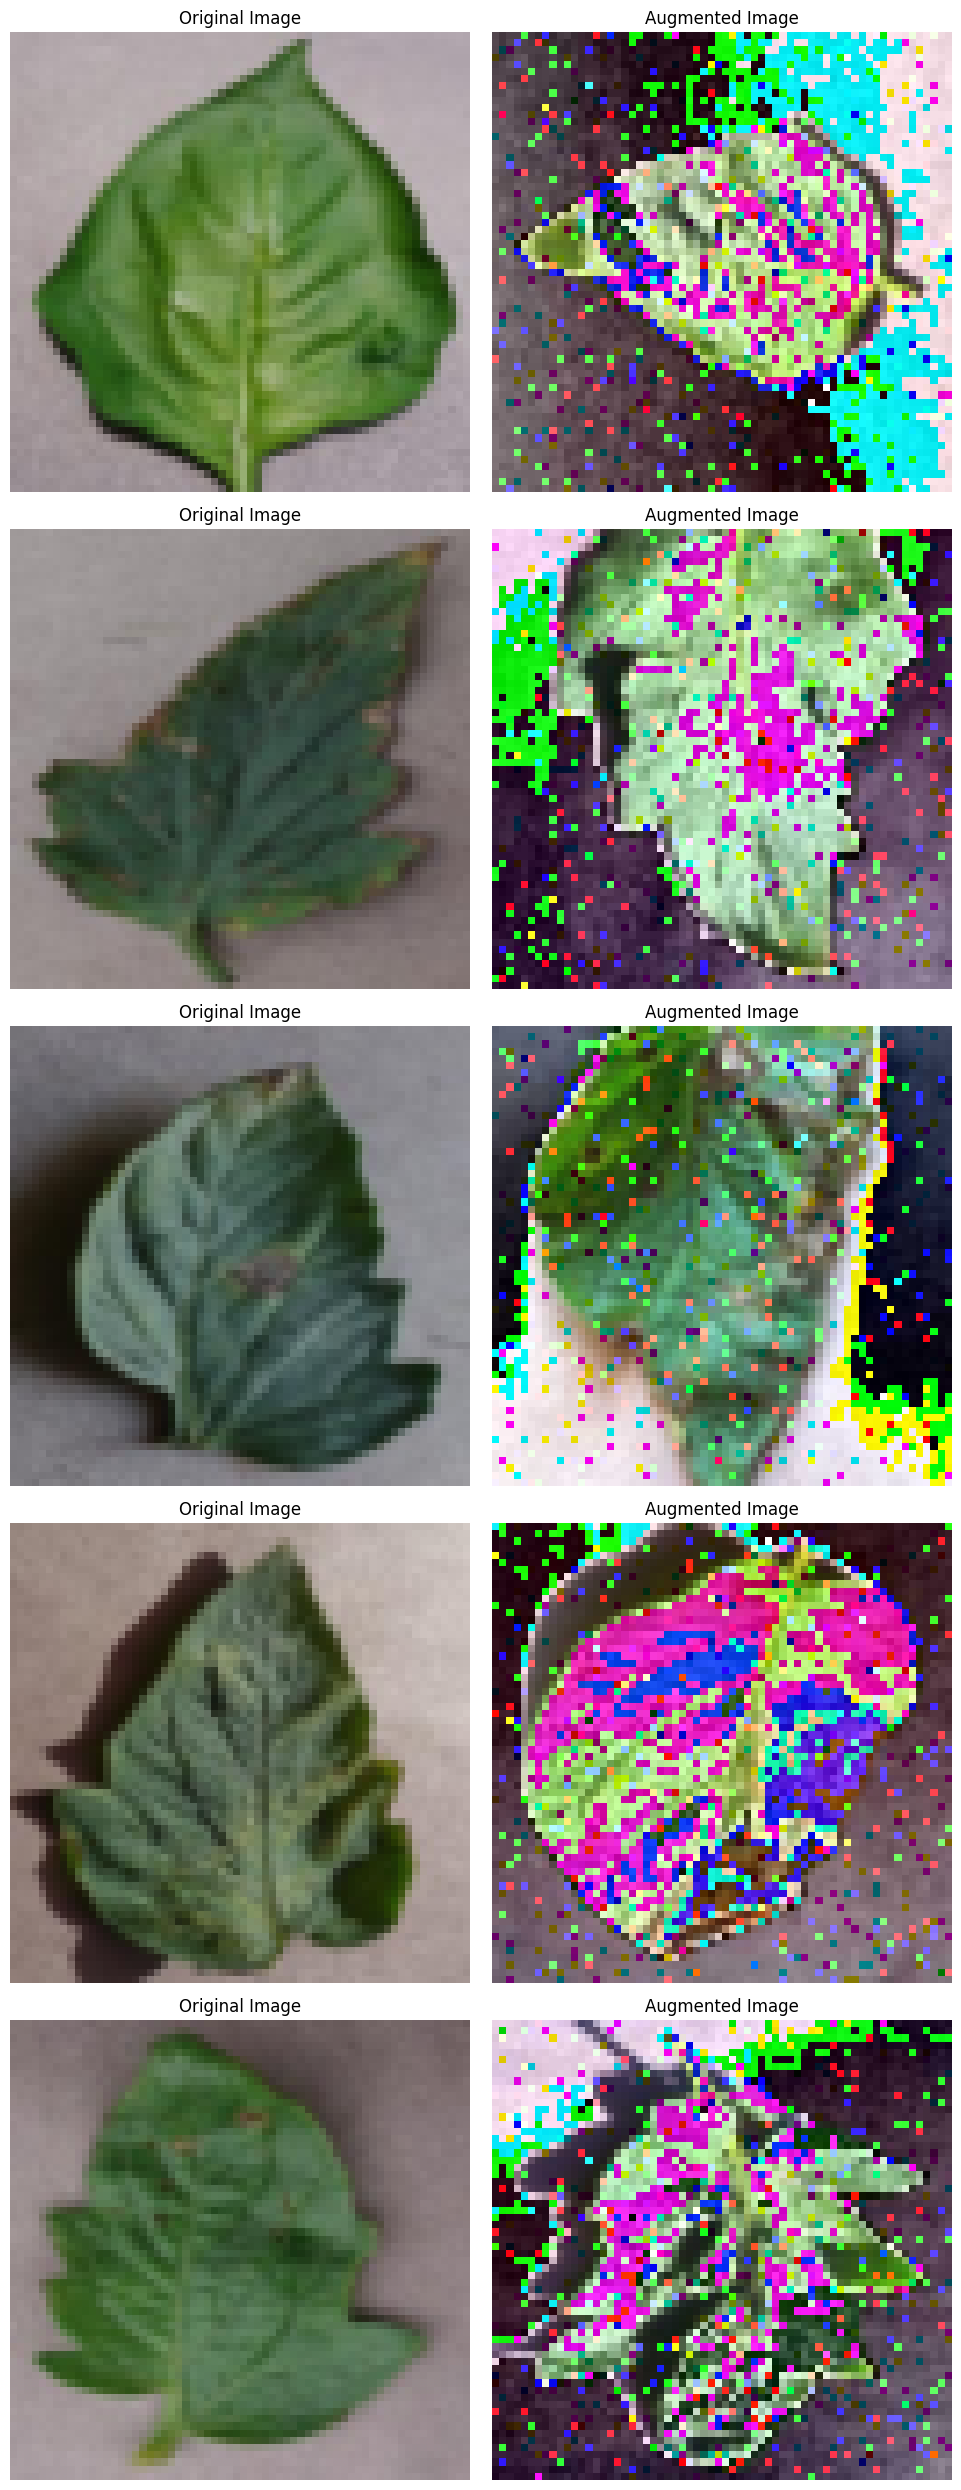

In [34]:
# Plot original and augmented images for visualization
import matplotlib.pyplot as plt

def plot_original_and_augmented(original_images, augmented_images, num_samples=5):
    """Plot some original images alongside their augmented counterparts."""
    plt.figure(figsize=(10, 5 * num_samples))
    for i in range(num_samples):
        original = original_images[i]
        augmented = augmented_images[i * 2]  # Augmented version of the same image

        # Ensure all images are converted to tensors
        if isinstance(original, torch.Tensor):
            original = to_pil(original)
        if isinstance(augmented, torch.Tensor):
            augmented = to_pil(augmented)

        # Plot original image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(original)
        plt.title("Original Image")
        plt.axis("off")

        # Plot augmented image
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(augmented)
        plt.title("Augmented Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Extract a few original images from the train dataset
original_images = [train_dataset.dataset[train_dataset.indices[i]][0] for i in range(5)]

# Visualize original and augmented images
plot_original_and_augmented(original_images, augmented_images)

Epoch 1/20 - Train Loss: 1.3939, F1: 0.3990
         Val Loss: 3.7734,  Val F1: 0.0682
Epoch 2/20 - Train Loss: 0.8760, F1: 0.5888
         Val Loss: 3.8132,  Val F1: 0.0848
Epoch 3/20 - Train Loss: 0.7056, F1: 0.6640
         Val Loss: 3.4082,  Val F1: 0.0993
Epoch 4/20 - Train Loss: 0.5957, F1: 0.6984
         Val Loss: 3.5708,  Val F1: 0.0670
Epoch 5/20 - Train Loss: 0.5228, F1: 0.7250
         Val Loss: 4.1300,  Val F1: 0.0765
Epoch 6/20 - Train Loss: 0.4697, F1: 0.7585
         Val Loss: 3.6977,  Val F1: 0.0807
Epoch 7/20 - Train Loss: 0.4152, F1: 0.7644
         Val Loss: 4.4239,  Val F1: 0.1181
Epoch 8/20 - Train Loss: 0.3809, F1: 0.7930
         Val Loss: 4.3542,  Val F1: 0.0818
Epoch 9/20 - Train Loss: 0.3518, F1: 0.7952
         Val Loss: 3.4083,  Val F1: 0.1380
Epoch 10/20 - Train Loss: 0.3221, F1: 0.8065
         Val Loss: 4.9526,  Val F1: 0.1236
Epoch 11/20 - Train Loss: 0.3044, F1: 0.8090
         Val Loss: 4.1628,  Val F1: 0.1234
Epoch 12/20 - Train Loss: 0.2788, F1: 0.8

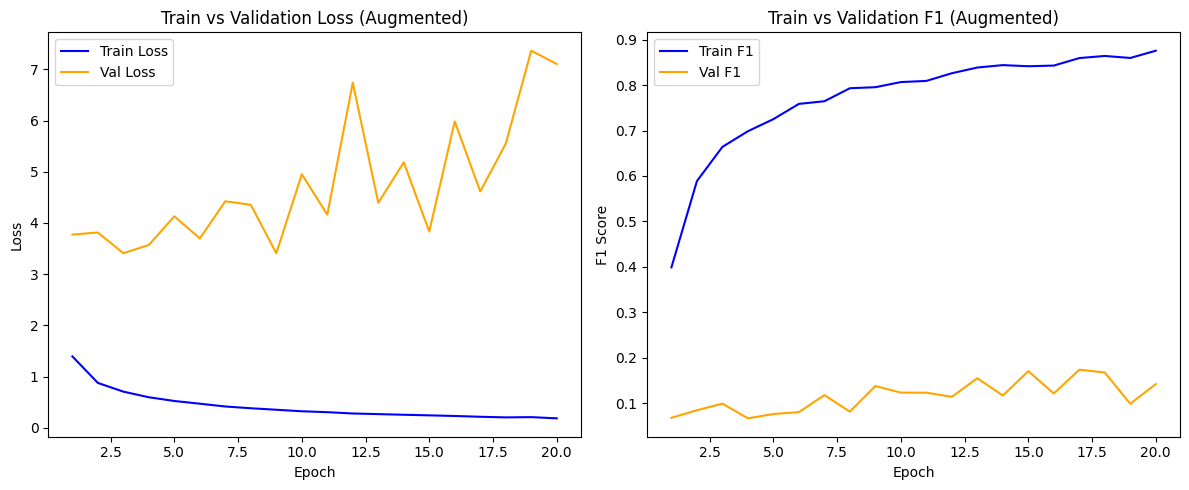

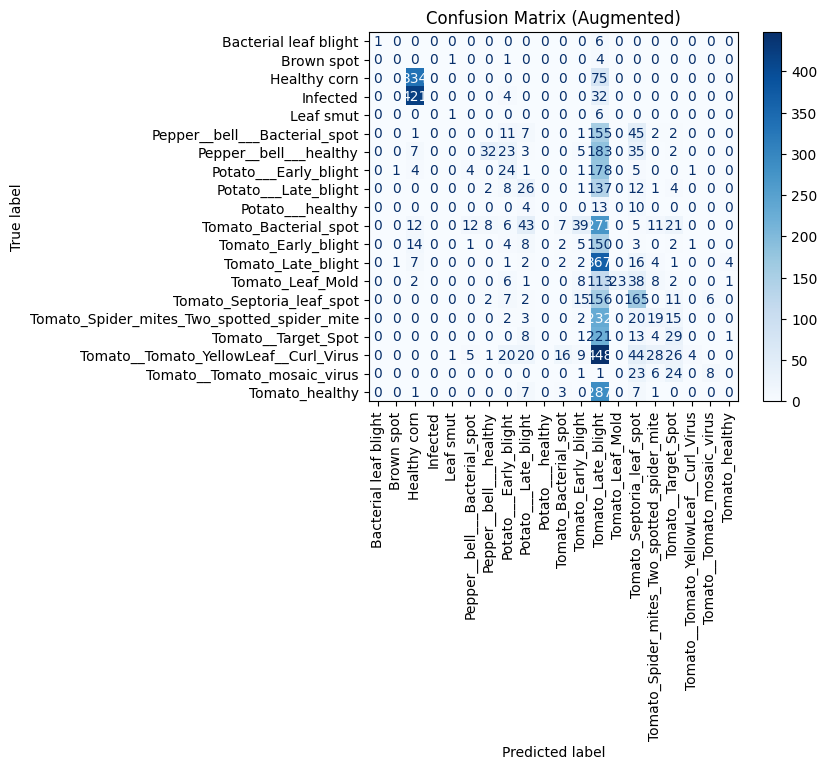

In [35]:
# ==========================
# 9) Create a TensorDataset
#    from the augmented data
# ==========================

# If your augmented_images are *already* [3, H, W] Tensors
# you can just do torch.stack directly.
combined_data = torch.stack(augmented_images)
combined_labels = torch.tensor(augmented_labels)

train_dataset_augmented = TensorDataset(combined_data, combined_labels)
train_loader_augmented = DataLoader(train_dataset_augmented,
                                    batch_size=batch_size,
                                    shuffle=True)

# ==========================
# 10) Build a "val_dataset" the same way
#     (If you want it as Tensors)
# ==========================
# But if your val_dataset is already loaded with base_transform, you can just
# create a normal DataLoader with an appropriate transform. Alternatively:

val_images, val_labels_list = zip(*[(img, lbl) for img, lbl in val_dataset])
# Convert each to a consistent Tensor shape
to_pil = transforms.ToPILImage()
resize_transform = transforms.Resize((img_height, img_width))

val_tensors = []
for img in val_images:
    # If for some reason 'img' is a Tensor, convert to PIL; else just use 'img'
    if isinstance(img, torch.Tensor):
        img = to_pil(img)
    # Then resize + to Tensor + (optional) normalize
    # (Here we'll do minimal transforms to keep it consistent.)
    val_pil = resize_transform(img)  
    val_tensor = transforms.ToTensor()(val_pil)
    # Or do your .Normalize here if you prefer:
    # val_tensor = transforms.Compose([
    #     transforms.Resize((img_height, img_width)),
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    # ])(img)
    val_tensors.append(val_tensor)

val_data = torch.stack(val_tensors)
val_labels = torch.tensor(val_labels_list)
val_dataset_augmented = TensorDataset(val_data, val_labels)

val_loader_augmented = DataLoader(val_dataset_augmented,
                                  batch_size=batch_size,
                                  shuffle=False)

# ==========================
# 11) Train & Validate
# ==========================

num_classes = len(dataset.classes)
model_augmented = CNNModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_augmented.parameters(), lr=0.001)

train_losses_augmented = []
val_losses_augmented   = []
train_f1_scores_augmented = []
val_f1_scores_augmented   = []

epochs = 20  # or 100, depending on your needs

for epoch in range(epochs):
    # 11a) Training
    model_augmented.train()
    running_loss = 0.0
    all_preds = []
    all_labels_gt = []

    for images_batch, labels_batch in train_loader_augmented:
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model_augmented(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels_gt.extend(labels_batch.cpu().numpy())

    train_loss = running_loss / len(train_loader_augmented)
    train_f1   = f1_score(all_labels_gt, all_preds, average='macro')

    train_losses_augmented.append(train_loss)
    train_f1_scores_augmented.append(train_f1)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, F1: {train_f1:.4f}")

    # 11b) Validation
    model_augmented.eval()
    val_running_loss = 0.0
    val_preds = []
    val_labels_gt = []

    with torch.no_grad():
        for val_images_batch, val_labels_batch in val_loader_augmented:
            val_images_batch = val_images_batch.to(device)
            val_labels_batch = val_labels_batch.to(device)

            val_outputs = model_augmented(val_images_batch)
            val_loss = criterion(val_outputs, val_labels_batch)
            val_running_loss += val_loss.item()

            _, val_predicted = val_outputs.max(1)
            val_preds.extend(val_predicted.cpu().numpy())
            val_labels_gt.extend(val_labels_batch.cpu().numpy())

    val_loss = val_running_loss / len(val_loader_augmented)
    val_f1   = f1_score(val_labels_gt, val_preds, average='macro')

    val_losses_augmented.append(val_loss)
    val_f1_scores_augmented.append(val_f1)

    print(f"         Val Loss: {val_loss:.4f},  Val F1: {val_f1:.4f}")

# ==========================
# 12) Plot Training Curves
# ==========================

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses_augmented, label='Train Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses_augmented,   label='Val Loss',   color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss (Augmented)')
plt.legend()

# F1
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_f1_scores_augmented, label='Train F1', color='blue')
plt.plot(range(1, epochs + 1), val_f1_scores_augmented,   label='Val F1',   color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Train vs Validation F1 (Augmented)')
plt.legend()

plt.tight_layout()
plt.show()

# ==========================
# 13) Evaluate with Confusion Matrix
# ==========================

model_augmented.eval()
val_preds = []
val_labels_gt = []

with torch.no_grad():
    for val_imgs_batch, val_lbls_batch in val_loader_augmented:
        val_imgs_batch = val_imgs_batch.to(device)
        val_lbls_batch = val_lbls_batch.to(device)

        val_outputs = model_augmented(val_imgs_batch)
        _, val_predicted = val_outputs.max(1)
        val_preds.extend(val_predicted.cpu().numpy())
        val_labels_gt.extend(val_lbls_batch.cpu().numpy())

cm_augmented = confusion_matrix(val_labels_gt, val_preds)
cmd_augmented = ConfusionMatrixDisplay(cm_augmented, display_labels=dataset.classes)
cmd_augmented.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix (Augmented)')
plt.show()



### More Tuning

Number of classes: 20
Epoch 1/20
  Train Loss: 1.0890, Train F1-Score: 0.4922
  Val Loss:   0.5275, Val F1-Score:   0.6873
  Best model saved.
Epoch 2/20
  Train Loss: 0.6574, Train F1-Score: 0.6595
  Val Loss:   0.3576, Val F1-Score:   0.7851
  Best model saved.
Epoch 3/20
  Train Loss: 0.5233, Train F1-Score: 0.7261
  Val Loss:   0.2906, Val F1-Score:   0.8218
  Best model saved.
Epoch 4/20
  Train Loss: 0.4435, Train F1-Score: 0.7499
  Val Loss:   0.2542, Val F1-Score:   0.8133
  No improvement for 1 epoch(s).
Epoch 5/20
  Train Loss: 0.3856, Train F1-Score: 0.7702
  Val Loss:   0.2229, Val F1-Score:   0.8367
  Best model saved.
Epoch 6/20
  Train Loss: 0.3316, Train F1-Score: 0.8030
  Val Loss:   0.1913, Val F1-Score:   0.8505
  Best model saved.
Epoch 7/20
  Train Loss: 0.2904, Train F1-Score: 0.8242
  Val Loss:   0.1932, Val F1-Score:   0.8424
  No improvement for 1 epoch(s).
Epoch 8/20
  Train Loss: 0.2669, Train F1-Score: 0.8424
  Val Loss:   0.1787, Val F1-Score:   0.8765
  Be

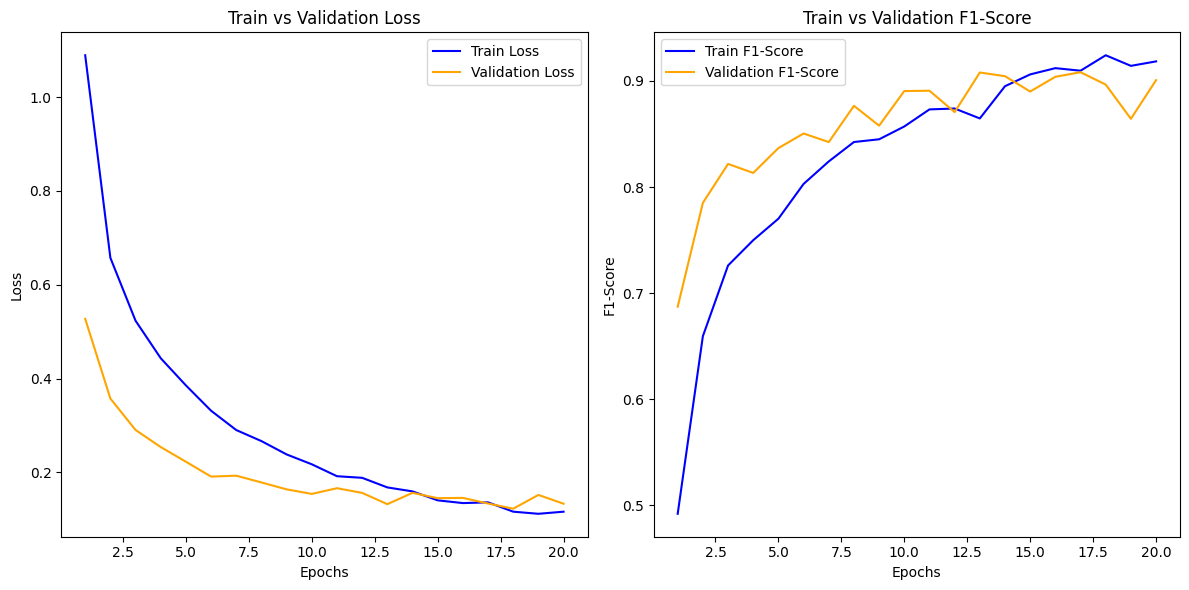

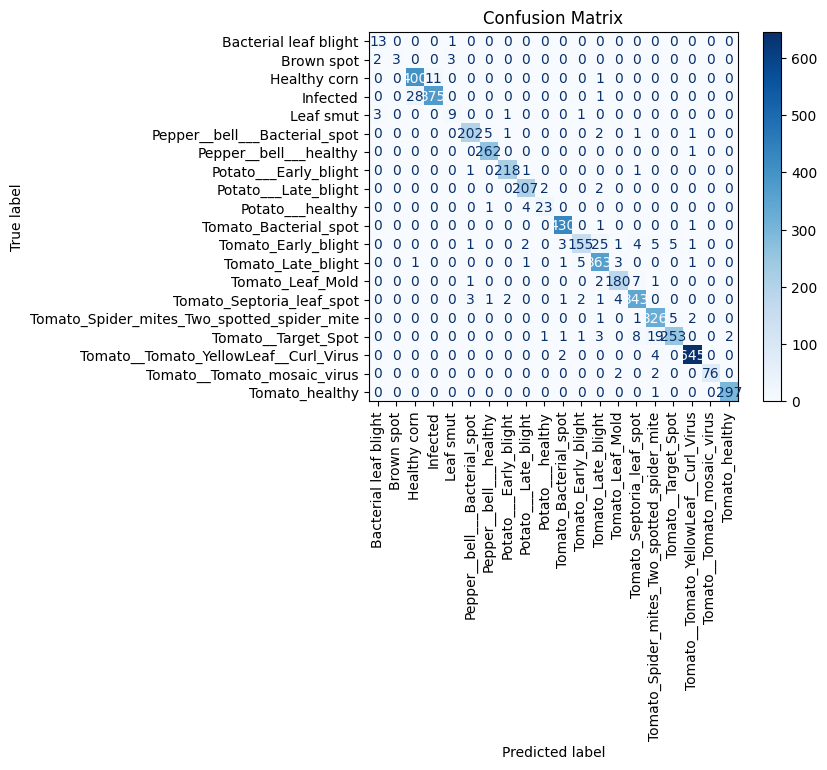

In [36]:
data_dir = 'clase'  # Path to the main folder containing subfolders (labels)
batch_size = 32
# Using a smaller dimension to train faster
img_height = 64
img_width = 64

# Define transforms 
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split dataset into training and validation sets
val_split = 0.2
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Get the number of classes
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

########################################################################
# 1) CNN Model with Dropout & Batch Normalization
########################################################################
class CNNModelDropoutBN(nn.Module):
    def __init__(self, num_classes):
        super(CNNModelDropoutBN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1),         # Dropout in the feature extractor
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2)
        )
        # Calculate the flattened size dynamically
        with torch.no_grad():
            sample_input = torch.zeros(1, 3, img_height, img_width)
            flattened_size = self.features(sample_input).view(1, -1).size(1)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout in the classifier
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

########################################################################
# 2) A Deeper CNN Model Example
########################################################################
class DeeperCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNNModel, self).__init__()
        # Example of a deeper architecture with more conv layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2),

            # Additional layers
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2)
        )
        
        # Calculate the flattened size
        with torch.no_grad():
            sample_input = torch.zeros(1, 3, img_height, img_width)
            flattened_size = self.features(sample_input).view(1, -1).size(1)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


########################################################################
# Choose which model you want to run:
# model = CNNModelDropoutBN(num_classes).to(device)
# OR
# model = DeeperCNNModel(num_classes).to(device)
########################################################################
model = CNNModelDropoutBN(num_classes).to(device)
# model = DeeperCNNModel(num_classes).to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

########################################################################
# 3) Early Stopping & Learning Rate Scheduler if no improvement for 3 epochs
########################################################################
from torch.optim.lr_scheduler import ReduceLROnPlateau

# We want to reduce LR if there's no improvement in the validation F1 for 3 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

epochs = 20
best_val_f1 = 0.0
best_model_path = 'best_model.pth'

train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

# For early stopping, we can track how many epochs passed without improvement
early_stop_patience = 5
epochs_no_improve = 0
stop_training = False

for epoch in range(epochs):
    if stop_training:
        break

    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_losses.append(train_loss)
    train_f1_scores.append(train_f1)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train F1-Score: {train_f1:.4f}")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_true = []

    with torch.no_grad():
        for val_images, val_labels_batch in val_loader:
            val_images, val_labels_batch = val_images.to(device), val_labels_batch.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels_batch)
            val_running_loss += val_loss.item()

            _, val_predicted = val_outputs.max(1)
            val_preds.extend(val_predicted.cpu().numpy())
            val_true.extend(val_labels_batch.cpu().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_f1 = f1_score(val_true, val_preds, average='macro')
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)

    print(f"  Val Loss:   {val_loss:.4f}, Val F1-Score:   {val_f1:.4f}")

    # Step the scheduler with the F1 score (mode='max')
    scheduler.step(val_f1)

    # Check for improvement
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print("  Best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s).")

    # Early stopping check
    if epochs_no_improve >= early_stop_patience:
        print(f"Stopping early after {epoch+1} epochs due to no improvement.")
        stop_training = True

# Save the final model
final_model_path = 'final_model.pth'
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot F1-scores
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, label='Train F1-Score', color='blue')
plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1-Score', color='orange')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('Train vs Validation F1-Score')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the best model on the validation set & display the confusion matrix
model.load_state_dict(torch.load(best_model_path))
model.eval()
val_preds = []
val_labels_list = []

with torch.no_grad():
    for val_images, val_labels_batch in val_loader:
        val_images, val_labels_batch = val_images.to(device), val_labels_batch.to(device)
        val_outputs = model(val_images)
        _, val_predicted = val_outputs.max(1)
        val_preds.extend(val_predicted.cpu().numpy())
        val_labels_list.extend(val_labels_batch.cpu().numpy())

cm = confusion_matrix(val_labels_list, val_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=dataset.classes)
cmd.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()